<a href="https://colab.research.google.com/github/Srishyl/Employee-promotion-prediction/blob/main/Employee_promotion_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Shape: (300, 4)

First few rows:
  date_of_birth date_of_joining  gender promoted
0    26-07-1983      09-11-2021    male       no
1    24-01-1989      06-01-2015  female       no
2    22-10-1967      19-01-2019    male       no
3    23-03-1990      18-05-2017    male       no
4    28-02-1980      07-08-2008  female      yes

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date_of_birth    300 non-null    object
 1   date_of_joining  300 non-null    object
 2   gender           300 non-null    object
 3   promoted         300 non-null    object
dtypes: object(4)
memory usage: 9.5+ KB
None

Missing Values:
date_of_birth      0
date_of_joining    0
gender             0
promoted           0
dtype: int64

Basic Statistics:
       date_of_birth date_of_joining gender promoted
count            300             300    300  

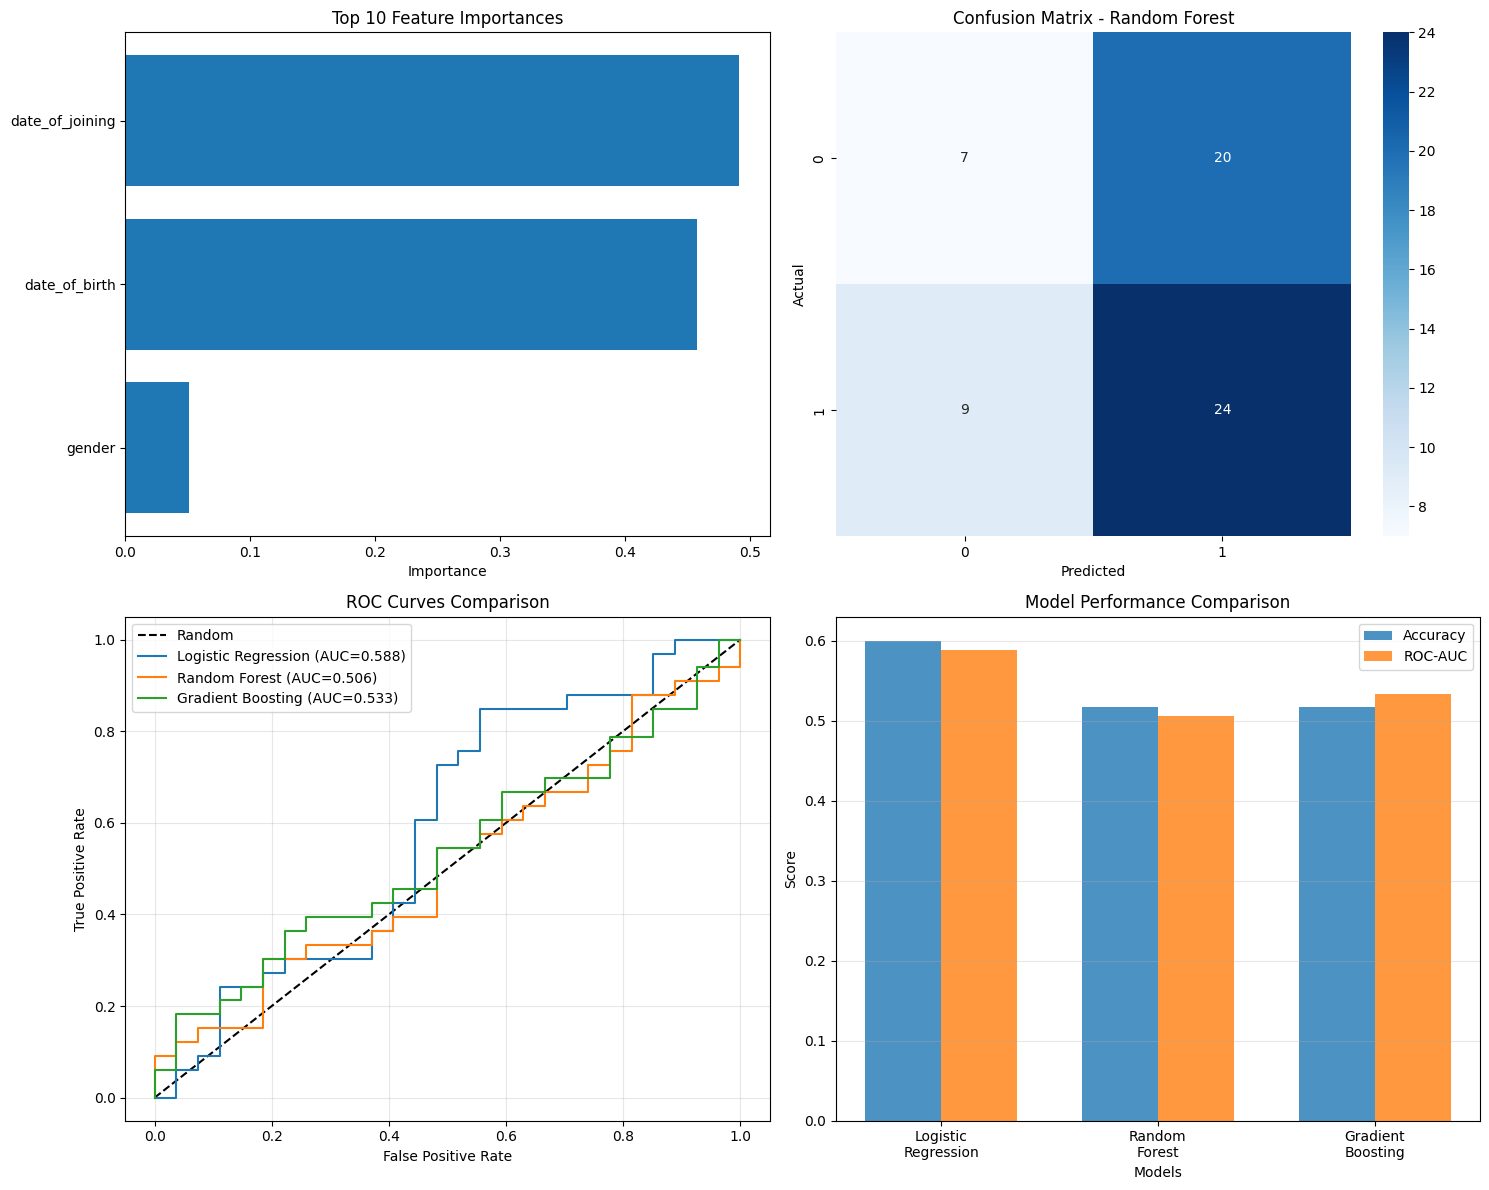


MODEL READY FOR PREDICTIONS
Use predict_promotion() function to predict promotion for new employees
Example: predict_promotion({date_of_birth: value, date_of_joining: value, ...})


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('/content/employee_promotions.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nBasic Statistics:")
print(df.describe())

# Check target variable distribution
if 'is_promoted' in df.columns:
    print("\nPromotion Distribution:")
    print(df['is_promoted'].value_counts())
    print(f"\nPromotion Rate: {df['is_promoted'].mean():.2%}")

# Data Preprocessing
df_clean = df.copy()

# Handle missing values
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
    else:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

# Encode categorical variables
le = LabelEncoder()
categorical_cols = df_clean.select_dtypes(include=['object']).columns

for col in categorical_cols:
    if col != 'employee_id':  # Don't encode ID columns
        df_clean[col] = le.fit_transform(df_clean[col].astype(str))

# Prepare features and target
target_col = 'is_promoted' if 'is_promoted' in df_clean.columns else df_clean.columns[-1]
exclude_cols = ['employee_id', 'Employee_ID', 'id', 'ID']
feature_cols = [col for col in df_clean.columns if col not in exclude_cols and col != target_col]

X = df_clean[feature_cols]
y = df_clean[target_col]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n" + "="*50)
print("MODEL TRAINING AND EVALUATION")
print("="*50)

# Model 1: Logistic Regression
print("\n1. Logistic Regression")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"Accuracy: {lr_model.score(X_test_scaled, y_test):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, lr_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_pred))

# Model 2: Random Forest
print("\n2. Random Forest Classifier")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {rf_model.score(X_test, y_test):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, rf_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

# Model 3: Gradient Boosting
print("\n3. Gradient Boosting Classifier")
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_pred_proba = gb_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {gb_model.score(X_test, y_test):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, gb_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, gb_pred))

# Feature Importance (Random Forest)
print("\n" + "="*50)
print("FEATURE IMPORTANCE (Random Forest)")
print("="*50)
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance.head(10))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Feature Importance
axes[0, 0].barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
axes[0, 0].set_xlabel('Importance')
axes[0, 0].set_title('Top 10 Feature Importances')
axes[0, 0].invert_yaxis()

# 2. Confusion Matrix (Random Forest)
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix - Random Forest')
axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_xlabel('Predicted')

# 3. ROC Curves
axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random')
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_pred_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba)
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_pred_proba)

axes[1, 0].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_auc_score(y_test, lr_pred_proba):.3f})')
axes[1, 0].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_score(y_test, rf_pred_proba):.3f})')
axes[1, 0].plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC={roc_auc_score(y_test, gb_pred_proba):.3f})')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curves Comparison')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Model Comparison
models = ['Logistic\nRegression', 'Random\nForest', 'Gradient\nBoosting']
accuracies = [
    lr_model.score(X_test_scaled, y_test),
    rf_model.score(X_test, y_test),
    gb_model.score(X_test, y_test)
]
roc_aucs = [
    roc_auc_score(y_test, lr_pred_proba),
    roc_auc_score(y_test, rf_pred_proba),
    roc_auc_score(y_test, gb_pred_proba)
]

x_pos = np.arange(len(models))
width = 0.35
axes[1, 1].bar(x_pos - width/2, accuracies, width, label='Accuracy', alpha=0.8)
axes[1, 1].bar(x_pos + width/2, roc_aucs, width, label='ROC-AUC', alpha=0.8)
axes[1, 1].set_xlabel('Models')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Model Performance Comparison')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(models)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Prediction function for new employees
def predict_promotion(employee_data, model=rf_model):
    """
    Predict promotion probability for a new employee
    employee_data: dictionary with feature values
    """
    df_new = pd.DataFrame([employee_data])
    for col in feature_cols:
        if col not in df_new.columns:
            df_new[col] = 0

    prediction_proba = model.predict_proba(df_new[feature_cols])[0]
    prediction = model.predict(df_new[feature_cols])[0]

    return {
        'promoted': bool(prediction),
        'promotion_probability': prediction_proba[1],
        'no_promotion_probability': prediction_proba[0]
    }

print("\n" + "="*50)
print("MODEL READY FOR PREDICTIONS")
print("="*50)
print("Use predict_promotion() function to predict promotion for new employees")
print(f"Example: predict_promotion({{{feature_cols[0]}: value, {feature_cols[1]}: value, ...}})")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                               VotingClassifier, AdaBoostClassifier)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("EMPLOYEE PROMOTION PREDICTION - OPTIMIZED MODEL")
print("="*60)

# Load the data
df = pd.read_csv('/content/employee_promotions.csv')

print(f"\nDataset Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

# Identify target column
possible_targets = ['is_promoted', 'promoted', 'promotion', 'target']
target_col = None
for col in possible_targets:
    if col in df.columns:
        target_col = col
        break
if target_col is None:
    target_col = df.columns[-1]

print(f"\nTarget Column: {target_col}")
print(f"Target Distribution:\n{df[target_col].value_counts()}")

# ✅ Fix: Ensure target column is numeric (map yes/no → 1/0 if needed)
if df[target_col].dtype == 'object':
    df[target_col] = df[target_col].astype(str).str.strip().str.lower()
    df[target_col] = df[target_col].map({
        'yes': 1, 'no': 0,
        'y': 1, 'n': 0,
        'promoted': 1, 'not promoted': 0
    }).fillna(df[target_col])  # leave as-is if already numeric

print(f"Promotion Rate: {df[target_col].mean():.2%}")

# Data Preprocessing
df_clean = df.copy()

print("\n" + "="*60)
print("DATA PREPROCESSING")
print("="*60)
print(f"Missing values before:\n{df_clean.isnull().sum()[df_clean.isnull().sum() > 0]}")

for col in df_clean.columns:
    if df_clean[col].isnull().sum() > 0:
        if df_clean[col].dtype == 'object':
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
        else:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)

print(f"Missing values after: {df_clean.isnull().sum().sum()}")

# Encode categorical variables
le_dict = {}
categorical_cols = df_clean.select_dtypes(include=['object']).columns

for col in categorical_cols:
    if col not in ['employee_id', 'Employee_ID', 'id', 'ID']:
        le_dict[col] = LabelEncoder()
        df_clean[col] = le_dict[col].fit_transform(df_clean[col].astype(str))

# Feature Engineering
print("\nFeature Engineering...")

numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != target_col and
                col not in ['employee_id', 'Employee_ID', 'id', 'ID']]

if len(numeric_cols) >= 2:
    df_clean['feature_interaction_1'] = df_clean[numeric_cols[0]] * df_clean[numeric_cols[1]]
    if len(numeric_cols) >= 3:
        df_clean['feature_interaction_2'] = df_clean[numeric_cols[0]] * df_clean[numeric_cols[2]]

# Prepare features and target
exclude_cols = ['employee_id', 'Employee_ID', 'id', 'ID', target_col]
feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

X = df_clean[feature_cols]
y = df_clean[target_col]

print(f"\nNumber of features: {len(feature_cols)}")
print(f"Features: {feature_cols[:10]}..." if len(feature_cols) > 10 else f"Features: {feature_cols}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Handle imbalanced data with SMOTE
print("\nApplying SMOTE for handling imbalanced data...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print(f"Training set after SMOTE: {X_train_balanced.shape}")
print(f"Class distribution after SMOTE:\n{pd.Series(y_train_balanced).value_counts()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print("\n" + "="*60)
print("MODEL TRAINING WITH HYPERPARAMETER TUNING")
print("="*60)

# XGBoost with hyperparameter tuning
print("\n1. XGBoost Classifier (Optimized)")
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
xgb_grid.fit(X_train_balanced, y_train_balanced)
print(f"Best parameters: {xgb_grid.best_params_}")
xgb_best = xgb_grid.best_estimator_
xgb_pred = xgb_best.predict(X_test)
xgb_pred_proba = xgb_best.predict_proba(X_test)[:, 1]
xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_auc = roc_auc_score(y_test, xgb_pred_proba)
print(f"Accuracy: {xgb_acc:.4f}")
print(f"ROC-AUC: {xgb_auc:.4f}")

# LightGBM with hyperparameter tuning
print("\n2. LightGBM Classifier (Optimized)")
lgbm_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 70]
}
lgbm_model = LGBMClassifier(random_state=42, verbose=-1)
lgbm_grid = GridSearchCV(lgbm_model, lgbm_params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
lgbm_grid.fit(X_train_balanced, y_train_balanced)
print(f"Best parameters: {lgbm_grid.best_params_}")
lgbm_best = lgbm_grid.best_estimator_
lgbm_pred = lgbm_best.predict(X_test)
lgbm_pred_proba = lgbm_best.predict_proba(X_test)[:, 1]
lgbm_acc = accuracy_score(y_test, lgbm_pred)
lgbm_auc = roc_auc_score(y_test, lgbm_pred_proba)
print(f"Accuracy: {lgbm_acc:.4f}")
print(f"ROC-AUC: {lgbm_auc:.4f}")

# Random Forest with optimization
print("\n3. Random Forest Classifier (Optimized)")
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
rf_grid.fit(X_train_balanced, y_train_balanced)
print(f"Best parameters: {rf_grid.best_params_}")
rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_test)
rf_pred_proba = rf_best.predict_proba(X_test)[:, 1]
rf_acc = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_pred_proba)
print(f"Accuracy: {rf_acc:.4f}")
print(f"ROC-AUC: {rf_auc:.4f}")

# Voting Ensemble
print("\n4. Voting Ensemble (XGBoost + LightGBM + Random Forest)")
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb_best),
        ('lgbm', lgbm_best),
        ('rf', rf_best)
    ],
    voting='soft',
    weights=[2, 2, 1]
)
voting_clf.fit(X_train_balanced, y_train_balanced)
voting_pred = voting_clf.predict(X_test)
voting_pred_proba = voting_clf.predict_proba(X_test)[:, 1]
voting_acc = accuracy_score(y_test, voting_pred)
voting_auc = roc_auc_score(y_test, voting_pred_proba)
print(f"Accuracy: {voting_acc:.4f}")
print(f"ROC-AUC: {voting_auc:.4f}")

# Select best model
models_performance = {
    'XGBoost': (xgb_acc, xgb_auc, xgb_best, xgb_pred, xgb_pred_proba),
    'LightGBM': (lgbm_acc, lgbm_auc, lgbm_best, lgbm_pred, lgbm_pred_proba),
    'Random Forest': (rf_acc, rf_auc, rf_best, rf_pred, rf_pred_proba),
    'Voting Ensemble': (voting_acc, voting_auc, voting_clf, voting_pred, voting_pred_proba)
}
best_model_name = max(models_performance, key=lambda x: models_performance[x][1])
best_acc, best_auc, best_model, best_pred, best_pred_proba = models_performance[best_model_name]

print("\n" + "="*60)
print(f"BEST MODEL: {best_model_name}")
print("="*60)
print(f"Accuracy: {best_acc:.4f}")
print(f"ROC-AUC: {best_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, best_pred))

# Feature Importance
print("\n" + "="*60)
print("FEATURE IMPORTANCE")
print("="*60)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    print(feature_importance.head(15))

# Prediction function
def predict_promotion(employee_data, return_proba=True):
    if isinstance(employee_data, dict):
        df_new = pd.DataFrame([employee_data])
    else:
        df_new = employee_data.copy()
    for col in feature_cols:
        if col not in df_new.columns:
            df_new[col] = 0
    df_new = df_new[feature_cols]
    if return_proba:
        proba = best_model.predict_proba(df_new)
        return pd.DataFrame({
            'no_promotion_prob': proba[:, 0],
            'promotion_prob': proba[:, 1],
            'predicted': (proba[:, 1] >= 0.5).astype(int)
        })
    else:
        return best_model.predict(df_new)

print("\n" + "="*60)
print("MODEL READY FOR PREDICTIONS!")
print("="*60)
print(f"Best Model: {best_model_name}")
print(f"Final Accuracy: {best_acc:.4f}")
print(f"Final ROC-AUC: {best_auc:.4f}")
print("\nUse predict_promotion(employee_data) to make predictions")


EMPLOYEE PROMOTION PREDICTION - OPTIMIZED MODEL

Dataset Shape: (300, 4)

Columns: ['date_of_birth', 'date_of_joining', 'gender', 'promoted']

First few rows:
  date_of_birth date_of_joining  gender promoted
0    26-07-1983      09-11-2021    male       no
1    24-01-1989      06-01-2015  female       no
2    22-10-1967      19-01-2019    male       no
3    23-03-1990      18-05-2017    male       no
4    28-02-1980      07-08-2008  female      yes

Target Column: promoted
Target Distribution:
promoted
yes    166
no     134
Name: count, dtype: int64
Promotion Rate: 55.33%

DATA PREPROCESSING
Missing values before:
Series([], dtype: int64)
Missing values after: 0

Feature Engineering...

Number of features: 5
Features: ['date_of_birth', 'date_of_joining', 'gender', 'feature_interaction_1', 'feature_interaction_2']

Applying SMOTE for handling imbalanced data...
Training set after SMOTE: (266, 5)
Class distribution after SMOTE:
promoted
1    133
0    133
Name: count, dtype: int64

MODEL 

In [4]:
# Employee Promotion Prediction - Corrected Code

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# ----------------------------
# Load Dataset
# ----------------------------
df = pd.read_csv("employee_promotions.csv")   # change to your dataset filename

print("\n📌 Dataset Preview:")
print(df.head())
print("\nDataset Info:")
print(df.info())

# ----------------------------
# Identify Target Column
# ----------------------------
possible_targets = ['is_promoted', 'promoted', 'promotion', 'target']
target_col = None
for col in possible_targets:
    if col in df.columns:
        target_col = col
        break
if target_col is None:
    target_col = df.columns[-1]  # assume last column is target

print(f"\n🎯 Target Column: {target_col}")
print("Target Distribution (before mapping):")
print(df[target_col].value_counts())

# ✅ Fix: Ensure target column is numeric (0/1)
if df[target_col].dtype == 'object':
    df[target_col] = df[target_col].astype(str).str.strip().str.lower()
    df[target_col] = df[target_col].map({
        'yes': 1, 'no': 0,
        'y': 1, 'n': 0,
        'promoted': 1, 'not promoted': 0
    }).fillna(df[target_col])  # keep as-is if already numeric

print("Target Distribution (after mapping):")
print(df[target_col].value_counts())
print(f"Promotion Rate: {df[target_col].mean():.2%}")

# ----------------------------
# Handle Missing Values
# ----------------------------
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

# ----------------------------
# Encode Categorical Columns
# ----------------------------
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

# ----------------------------
# Split Features & Target
# ----------------------------
X = df.drop(columns=[target_col])
y = df[target_col]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ----------------------------
# Balance Data (SMOTE)
# ----------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\n✅ After SMOTE Balancing:")
print(y_train_res.value_counts())

# ----------------------------
# Scale Features
# ----------------------------
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

# ----------------------------
# Train Models
# ----------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42)
}

for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)

    print(f"\n🔎 {name} Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))



📌 Dataset Preview:
  date_of_birth date_of_joining  gender promoted
0    26-07-1983      09-11-2021    male       no
1    24-01-1989      06-01-2015  female       no
2    22-10-1967      19-01-2019    male       no
3    23-03-1990      18-05-2017    male       no
4    28-02-1980      07-08-2008  female      yes

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date_of_birth    300 non-null    object
 1   date_of_joining  300 non-null    object
 2   gender           300 non-null    object
 3   promoted         300 non-null    object
dtypes: object(4)
memory usage: 9.5+ KB
None

🎯 Target Column: promoted
Target Distribution (before mapping):
promoted
yes    166
no     134
Name: count, dtype: int64
Target Distribution (after mapping):
promoted
1    166
0    134
Name: count, dtype: int64
Promotion Rate: 55.33%

✅ After SMOTE Ba

In [5]:
import pandas as pd
import numpy as np
import gradio as gr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import joblib

# ----------------------------
# Load Dataset
# ----------------------------
df = pd.read_csv("employee_promotions.csv")   # change this to your dataset

# ----------------------------
# Identify Target Column
# ----------------------------
possible_targets = ['is_promoted', 'promoted', 'promotion', 'target']
target_col = None
for col in possible_targets:
    if col in df.columns:
        target_col = col
        break
if target_col is None:
    target_col = df.columns[-1]  # assume last column is target

# Convert target column to numeric
if df[target_col].dtype == 'object':
    df[target_col] = df[target_col].astype(str).str.strip().str.lower()
    df[target_col] = df[target_col].map({
        'yes': 1, 'no': 0,
        'y': 1, 'n': 0,
        'promoted': 1, 'not promoted': 0
    }).fillna(df[target_col])

# ----------------------------
# Handle Missing Values
# ----------------------------
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

# ----------------------------
# Encode Categorical Columns
# ----------------------------
label_encoders = {}
for col in df.columns:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# ----------------------------
# Split Features & Target
# ----------------------------
X = df.drop(columns=[target_col])
y = df[target_col]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ----------------------------
# Balance Data (SMOTE)
# ----------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# ----------------------------
# Scale Features
# ----------------------------
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

# ----------------------------
# Train Best Model (Random Forest here)
# ----------------------------
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train_res, y_train_res)

# Save model + scaler + encoders for reuse
joblib.dump((model, scaler, label_encoders, X.columns.tolist()), "promotion_model.pkl")

# ----------------------------
# Prediction Function for Gradio
# ----------------------------
def predict_promotion(**inputs):
    # Load saved model
    model, scaler, label_encoders, feature_names = joblib.load("promotion_model.pkl")

    # Prepare input
    input_data = []
    for col in feature_names:
        val = inputs.get(col, 0)

        # Apply label encoding if needed
        if col in label_encoders:
            try:
                val = label_encoders[col].transform([val])[0]
            except:
                val = 0
        input_data.append(val)

    # Scale input
    input_scaled = scaler.transform([input_data])

    # Predict
    pred = model.predict(input_scaled)[0]
    prob = model.predict_proba(input_scaled)[0][1]

    return {"Promotion Prediction": "Yes" if pred == 1 else "No",
            "Probability": f"{prob:.2%}"}

# ----------------------------
# Build Gradio Interface
# ----------------------------
inputs = []
for col in X.columns:
    if col in label_encoders:
        choices = list(label_encoders[col].classes_)
        inputs.append(gr.Dropdown(choices=choices, label=col))
    else:
        inputs.append(gr.Number(label=col))

iface = gr.Interface(
    fn=predict_promotion,
    inputs=inputs,
    outputs=[gr.Label(label="Prediction")],
    title="👔 Employee Promotion Prediction",
    description="Enter employee details to predict whether they will be promoted."
)

# ----------------------------
# Launch App
# ----------------------------
if __name__ == "__main__":
    iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://658dfc53387a5190b1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [7]:
import pandas as pd
import numpy as np
import gradio as gr
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import joblib

# ----------------------------
# Load Dataset
# ----------------------------
df = pd.read_csv("employee_promotions.csv")   # change to your dataset filename

# ----------------------------
# Identify Target Column
# ----------------------------
possible_targets = ['is_promoted', 'promoted', 'promotion', 'target']
target_col = None
for col in possible_targets:
    if col in df.columns:
        target_col = col
        break
if target_col is None:
    target_col = df.columns[-1]  # assume last column is target

# Convert target column to numeric
if df[target_col].dtype == 'object':
    df[target_col] = df[target_col].astype(str).str.strip().str.lower()
    df[target_col] = df[target_col].map({
        'yes': 1, 'no': 0,
        'y': 1, 'n': 0,
        'promoted': 1, 'not promoted': 0
    }).fillna(df[target_col])

# ----------------------------
# Convert Dates to Numeric
# ----------------------------
if "date_of_birth" in df.columns and "date_of_joining" in df.columns:
    df["date_of_birth"] = pd.to_datetime(df["date_of_birth"], errors="coerce")
    df["date_of_joining"] = pd.to_datetime(df["date_of_joining"], errors="coerce")

    today = pd.to_datetime("today")
    df["age"] = today.year - df["date_of_birth"].dt.year
    df["years_at_company"] = today.year - df["date_of_joining"].dt.year

    df.drop(columns=["date_of_birth", "date_of_joining"], inplace=True)

# ----------------------------
# Handle Missing Values
# ----------------------------
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

# ----------------------------
# Encode Categorical Columns
# ----------------------------
label_encoders = {}
for col in df.columns:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# ----------------------------
# Split Features & Target
# ----------------------------
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ----------------------------
# Balance Data (SMOTE)
# ----------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# ----------------------------
# Scale Features
# ----------------------------
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

# ----------------------------
# Train Model (Random Forest)
# ----------------------------
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train_res, y_train_res)

# Save model
joblib.dump((model, scaler, label_encoders, X.columns.tolist()), "promotion_model.pkl")

# ----------------------------
# Prediction Function for Gradio
# ----------------------------
def predict_promotion(**inputs):
    model, scaler, label_encoders, feature_names = joblib.load("promotion_model.pkl")

    input_data = []
    for col in feature_names:
        val = inputs.get(col, 0)

        # Encode categorical values if needed
        if col in label_encoders:
            try:
                val = label_encoders[col].transform([val])[0]
            except:
                val = 0
        input_data.append(val)

    input_scaled = scaler.transform([input_data])
    pred = model.predict(input_scaled)[0]
    prob = model.predict_proba(input_scaled)[0][1]

    return {
        "Promotion Prediction": "Yes" if pred == 1 else "No",
        "Probability": f"{prob:.2%}"
    }

# ----------------------------
# Build Gradio UI
# ----------------------------
inputs = []
for col in X.columns:
    if col in label_encoders:  # categorical → dropdown
        choices = list(label_encoders[col].classes_)
        inputs.append(gr.Dropdown(choices=choices, label=col))
    else:  # numeric → number input
        inputs.append(gr.Number(label=col))

iface = gr.Interface(
    fn=predict_promotion,
    inputs=inputs,
    outputs=[gr.Label(label="Prediction")],
    title="👔 Employee Promotion Prediction",
    description="Enter employee details (numeric + categorical) to predict whether they will be promoted."
)

if __name__ == "__main__":
    iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://96ecac4e8668d7cc0e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [9]:
import pandas as pd
import numpy as np
import gradio as gr
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib

# ----------------------------
# Load dataset
# ----------------------------
df = pd.read_csv("/content/employee_promotions.csv")  # change path

# ----------------------------
# Preprocess dataset
# ----------------------------
# Convert target column
df["promoted"] = df["promoted"].astype(str).str.strip().str.lower()
df["promoted"] = df["promoted"].map({"yes": 1, "no": 0})

# Convert dates
df["date_of_birth"] = pd.to_datetime(df["date_of_birth"], errors="coerce", dayfirst=True)
df["date_of_joining"] = pd.to_datetime(df["date_of_joining"], errors="coerce", dayfirst=True)

today = pd.to_datetime("today")
df["age"] = today.year - df["date_of_birth"].dt.year
df["years_at_company"] = today.year - df["date_of_joining"].dt.year

# Encode gender
le_gender = LabelEncoder()
df["gender"] = le_gender.fit_transform(df["gender"].astype(str))

# Final dataset
X = df[["age", "years_at_company", "gender"]]
y = df["promoted"]

# ----------------------------
# Train model
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train_scaled, y_train)

print("Accuracy:", accuracy_score(y_test, model.predict(X_test_scaled)))

# Save model
joblib.dump((model, scaler, le_gender), "promotion_model.pkl")

# ----------------------------
# Prediction function
# ----------------------------
def predict_promotion(date_of_birth, date_of_joining, gender):
    # Load model
    model, scaler, le_gender = joblib.load("promotion_model.pkl")

    # Convert dates
    dob = pd.to_datetime(date_of_birth, errors="coerce", dayfirst=True)
    doj = pd.to_datetime(date_of_joining, errors="coerce", dayfirst=True)
    today = pd.to_datetime("today")

    if pd.isnull(dob) or pd.isnull(doj):
        return {"Error": "Invalid date format. Use DD-MM-YYYY"}

    age = today.year - dob.year
    years_at_company = today.year - doj.year

    # Encode gender
    try:
        gender_val = le_gender.transform([gender])[0]
    except:
        gender_val = 0

    # Prepare input
    input_data = np.array([[age, years_at_company, gender_val]])
    input_scaled = scaler.transform(input_data)

    # Prediction
    pred = model.predict(input_scaled)[0]
    prob = model.predict_proba(input_scaled)[0][1]

    return {
        "Promotion Prediction": "Yes" if pred == 1 else "No",
        "Probability": f"{prob:.2%}"
    }

# ----------------------------
# Gradio UI
# ----------------------------
iface = gr.Interface(
    fn=predict_promotion,
    inputs=[
        gr.Textbox(label="Date of Birth (DD-MM-YYYY)", placeholder="01-03-1988"),
        gr.Textbox(label="Date of Joining (DD-MM-YYYY)", placeholder="01-01-2020"),
        gr.Dropdown(["male", "female"], label="Gender")
    ],
    outputs=[gr.Label(label="Prediction")],
    title="👔 Employee Promotion Prediction",
    description="Enter employee DOB, DOJ, and Gender to predict promotion."
)

if __name__ == "__main__":
    iface.launch()


Accuracy: 0.95
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0d6f182853e5a6c0ad.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [11]:
import pandas as pd
import numpy as np
import gradio as gr
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib
import re

# ----------------------------
# Load dataset
# ----------------------------
df = pd.read_csv("/content/employee_promotions.csv")  # change path

# ----------------------------
# Preprocess dataset
# ----------------------------
df["promoted"] = df["promoted"].astype(str).str.strip().str.lower()
df["promoted"] = df["promoted"].map({"yes": 1, "no": 0})

df["date_of_birth"] = pd.to_datetime(df["date_of_birth"], errors="coerce", dayfirst=True)
df["date_of_joining"] = pd.to_datetime(df["date_of_joining"], errors="coerce", dayfirst=True)

today = pd.to_datetime("today")
df["age"] = today.year - df["date_of_birth"].dt.year
df["years_at_company"] = today.year - df["date_of_joining"].dt.year

le_gender = LabelEncoder()
df["gender"] = le_gender.fit_transform(df["gender"].astype(str))

X = df[["age", "years_at_company", "gender"]]
y = df["promoted"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train_scaled, y_train)

print("Accuracy:", accuracy_score(y_test, model.predict(X_test_scaled)))

joblib.dump((model, scaler, le_gender), "promotion_model.pkl")

# ----------------------------
# Chatbot prediction function
# ----------------------------
def chatbot(message, history):
    model, scaler, le_gender = joblib.load("promotion_model.pkl")

    # Extract DOB, DOJ, Gender from user message
    dob_match = re.search(r"dob\s*[:\-]?\s*(\d{2}-\d{2}-\d{4})", message, re.I)
    doj_match = re.search(r"doj\s*[:\-]?\s*(\d{2}-\d{2}-\d{4})", message, re.I)
    gender_match = re.search(r"(male|female)", message, re.I)

    if not dob_match or not doj_match or not gender_match:
        return "❗ Please provide details in format: 'DOB: DD-MM-YYYY, DOJ: DD-MM-YYYY, Gender: male/female'"

    dob = pd.to_datetime(dob_match.group(1), errors="coerce", dayfirst=True)
    doj = pd.to_datetime(doj_match.group(1), errors="coerce", dayfirst=True)
    gender = gender_match.group(1).lower()

    today = pd.to_datetime("today")
    age = today.year - dob.year
    years_at_company = today.year - doj.year
    gender_val = le_gender.transform([gender])[0]

    input_data = np.array([[age, years_at_company, gender_val]])
    input_scaled = scaler.transform(input_data)

    pred = model.predict(input_scaled)[0]
    prob = model.predict_proba(input_scaled)[0][1]

    return f"✅ Promotion Prediction: {'Yes 🎉' if pred==1 else 'No ❌'}\n📊 Probability: {prob:.2%}"

# ----------------------------
# Gradio ChatInterface
# ----------------------------
chatbot_ui = gr.ChatInterface(
    fn=chatbot,
    title="👔 Employee Promotion Chatbot",
    description="Ask me about promotion chances.\nExample: 'DOB: 01-03-1988, DOJ: 01-01-2020, Gender: female'"
)

if __name__ == "__main__":
    chatbot_ui.launch()


Accuracy: 0.95
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8f582f0a123d86d44d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [13]:
import pandas as pd
import numpy as np
import gradio as gr
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import joblib
import re


df = pd.read_csv("/content/employee_promotions.csv")


df["promoted"] = df["promoted"].astype(str).str.strip().str.lower()
df["promoted"] = df["promoted"].map({"yes": 1, "no": 0})

df["date_of_birth"] = pd.to_datetime(df["date_of_birth"], errors="coerce", dayfirst=True)
df["date_of_joining"] = pd.to_datetime(df["date_of_joining"], errors="coerce", dayfirst=True)

today = pd.to_datetime("today")
df["age"] = today.year - df["date_of_birth"].dt.year
df["years_at_company"] = today.year - df["date_of_joining"].dt.year

le_gender = LabelEncoder()
df["gender"] = le_gender.fit_transform(df["gender"].astype(str))

X = df[["age", "years_at_company", "gender"]]
y = df["promoted"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train_scaled, y_train)

joblib.dump((model, scaler, le_gender), "promotion_model.pkl")


def predict_promotion(text):
    model, scaler, le_gender = joblib.load("promotion_model.pkl")

    dob_match = re.search(r"dob\s*[:\-]?\s*(\d{2}-\d{2}-\d{4})", text, re.I)
    doj_match = re.search(r"doj\s*[:\-]?\s*(\d{2}-\d{2}-\d{4})", text, re.I)
    gender_match = re.search(r"(male|female)", text, re.I)

    if not dob_match or not doj_match or not gender_match:
        return "❗ Please enter details as: DOB: DD-MM-YYYY, DOJ: DD-MM-YYYY, Gender: male/female"

    dob = pd.to_datetime(dob_match.group(1), errors="coerce", dayfirst=True)
    doj = pd.to_datetime(doj_match.group(1), errors="coerce", dayfirst=True)
    gender = gender_match.group(1).lower()

    today = pd.to_datetime("today")
    age = today.year - dob.year
    years_at_company = today.year - doj.year
    gender_val = le_gender.transform([gender])[0]

    input_data = np.array([[age, years_at_company, gender_val]])
    input_scaled = scaler.transform(input_data)

    pred = model.predict(input_scaled)[0]
    return "✅ Promoted: Yes 🎉" if pred == 1 else "❌ Promoted: No"


demo = gr.Interface(
    fn=predict_promotion,
    inputs=gr.Textbox(label="Enter Employee Details", placeholder="Example: DOB: 01-03-1988, DOJ: 01-01-2020, Gender: female"),
    outputs="text",
    title="👔 Employee Promotion Predictor"
)

if __name__ == "__main__":
    demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d5884b9094a116bddd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [14]:
!git --version


git version 2.34.1


In [15]:
!git config --global user.name "Srishyl"
!git config --global user.email "srishylkumar29@gmail.com"


In [16]:
!git clone https://github.com/Srishyl/Employee-promotion-prediction.git


Cloning into 'Employee-promotion-prediction'...


In [17]:
!git add .



fatal: not a git repository (or any of the parent directories): .git


In [18]:
!cp "Employee promotion prediction.ipynb" Employee-promotion-prediction/


cp: cannot stat 'Employee promotion prediction.ipynb': No such file or directory
